# Education Infrastructure

In this notebook, we will perform a **damage and risk assessment** for education infrastructure. The assessment is based on combining hazard data (e.g., flood depths) with vulnerability curves to estimate the potential damage to infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., secondary schools) and hazard data (e.g., flood depths) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the damage assessment:**  
   We will apply vulnerability curves to estimate the potential damage based on the intensity of the hazard.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on education infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install rioxarray
#!pip install contextily
#!pip install exactextract
#!pip install osm-flex

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [2]:
import os,sys
import rasterio
import shapely
import xarray as xr

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import rioxarray
import contextily as cx

from osm_flex import download
from exactextract import exact_extract

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [3]:
country_full_name = 'Jamaica'
country_iso3 = 'JAM'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

3. **Vulnerability curves:**  
   Vulnerability curves define how the infrastructure's damage increases with the intensity of the hazard. For example, flood depth-damage curves specify how much damage occurs for different flood depths.

4. **Maximum damage values:**  
   This dataset contains the maximum possible damage (in monetary terms) that can be incurred by individual infrastructure assets. This is crucial for calculating total damage based on the vulnerability curves.

### Infrastructure Data

We will perform this example analysis for Jamaica. To start the analysis, we first download the OpenStreetMap data from GeoFabrik. 

In [4]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the healthcare data.

In [5]:
%%time
features = gpd.read_file(infrastructure_path, layer="multipolygons")

CPU times: total: 15.8 s
Wall time: 29.9 s


In [6]:
sub_types = ['school', 'kindergarten', 'college', 'library','university','childcare']

In [7]:
features = features[features['amenity'].isin(sub_types)].reset_index(drop=True)
features = features.to_crs(3857)

### Hazard Data
For this example, we make use of the flood data provided by [CDRI](https://giri.unepgrid.ch/map?list=explore).

We use a 1/100 flood map to showcase the approach.

In [8]:
hazard_map = xr.open_dataset("https://hazards-data.unepgrid.ch/global_pc_h100glob.tif", engine="rasterio")

### Maximum damages
One of the most difficult parts of the assessment is to define the maximum reconstruction cost of particular assets. Here we provide a baseline set of values, but these should be updated through national consultations.

In [9]:
maxdam_dict = {
        'school':1500, 
        'kindergarten':1000, 
        'library':2000, 
        'college':1500,
        'university':2000, 
        'childcare':1000,}

### Vulnerability data
Similarly to the maximum damages, specifying the vulnerability curves is complex. We generally have limited information about the quality of the assets, its level of deteriation and other asset-level characteristics.

In [10]:
vulnerability_path = "https://zenodo.org/records/10203846/files/Table_D2_Multi-Hazard_Fragility_and_Vulnerability_Curves_V1.0.0.xlsx?download=1"
vul_df = pd.read_excel(vulnerability_path,sheet_name='F_Vuln_Depth')

And let's have a look at all the available options

In [11]:
with pd.option_context('display.max_rows', None):
  display(vul_df.iloc[:2,:].T)

,0,1
ID number,Infrastructure description,Additional characteristics
F1.1,plant,"Small power plants, capacity <100 MW"
F1.2,plant,"Medium power plants, capacity 100-500 MW"
F1.3,plant,"Large power plants, >500 MW"
F1.4,plant,thermal plant
F1.5,plant,wind turbine
F1.6,plant,wind turbine
F1.7,plant,wind turbine
F2.1,substation,Low Voltage Substation
F2.2,substation,Medium Voltage Substation


And select a curve to use for each different subtype we are analysing.

In [12]:
sub_types

['school', 'kindergarten', 'college', 'library', 'university', 'childcare']

In [13]:
selected_curves = dict(zip(sub_types,['F21.7','F21.7','F21.7','F21.7','F21.7','F21.7']))

In [14]:
damage_curves = vul_df[['ID number']+list(selected_curves.values())]
damage_curves = damage_curves.iloc[4:125,:]
damage_curves.set_index('ID number',inplace=True)
damage_curves.index = damage_curves.index.rename('Depth')  
damage_curves.columns = sub_types

### Ancilliary data for processing

In [15]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

## 3. Preparing the Data

Change the column name of the object data, to ensure we can use the same functions across different infrastructure assets

In [16]:
features = features.rename(columns = {'amenity' : 'object_type'})

Clip the hazard data to the country of interest.

In [17]:
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [20]:
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )

## 4. Intersecting hazard and feature informatoin

In the next step, we have to ensure that we can run this in every country, irrespective of its size. To ensure this, we first cut the country into smaller pieces through a grid. This is done in the **create_grid** function below.

In [21]:
def create_grid(bbox,height):
    """Create a vector-based grid

    Args:
        bbox ([type]): [description]
        height ([type]): [description]

    Returns:
        [type]: [description]
    """    

    # set xmin,ymin,xmax,and ymax of the grid
    xmin, ymin = shapely.total_bounds(bbox)[0],shapely.total_bounds(bbox)[1]
    xmax, ymax = shapely.total_bounds(bbox)[2],shapely.total_bounds(bbox)[3]
    
    #estimate total rows and columns
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / height))

    # set corner points
    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    # create actual grid
    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                ((x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                )))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height

    # return grid as shapely polygons
    return shapely.polygons(res_geoms)


For the grid, we want to specify a size of the each cell. It generally makes sense to use 1 or 0.5 degree. You can set the size in the box below. Following, we create the grid.

In [22]:
grid_cell_size = 0.5 # in degrees

gridded = create_grid(shapely.box(hazard_country.rio.bounds()[0],hazard_country.rio.bounds()[1],hazard_country.rio.bounds()[2],
                                      hazard_country.rio.bounds()[3]),grid_cell_size)
    
# get all bounds
all_bounds = gpd.GeoDataFrame(gridded,columns=['geometry']).bounds

And let's have a look how this looks

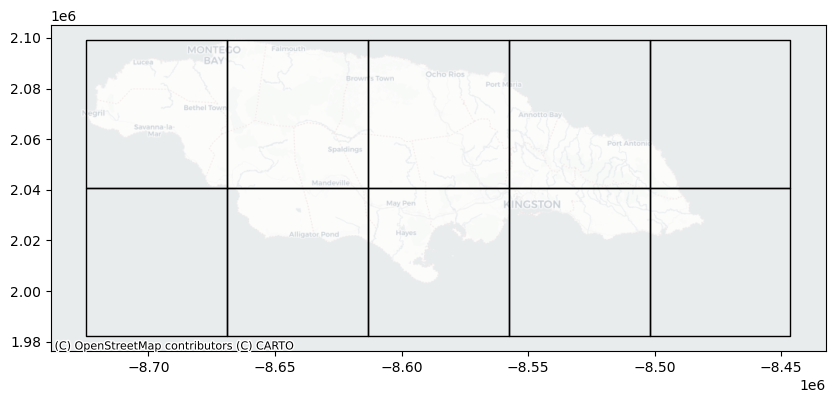

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
gpd.GeoDataFrame(gridded,columns=['geometry']).set_crs(4326).to_crs(3857).plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)

Now we perform perform the following steps to overlay the hazard and feature data:

* We loop over the individual grid cells.
* We clip the hazard information to each individual grid cell.
* We clip the feature information to each individual grid cell.
* We reproject the hazard data to **EPSG:3857** so we ensure that we can overlay this with the features we will analyse, and have all the overlay in meters.
* We perform the overlay using the [*exact_extract*](https://isciences.github.io/exactextract/) function.
* We make sure the output of *extact_extract* will match with the index of the features.
* We store all the outputs in a single list, to merge with the features later.

In [24]:
# create a list to collect the subsets
collect_subsets = []

#features to clip
features_to_clip = features.to_crs(4326)

collect_overlay = []

# loop over all grids
for bounds in tqdm(all_bounds.itertuples(),total=len(all_bounds)):
    try:
        # subset hazard
        subset_hazard = hazard_country.rio.clip_box(
        minx=bounds.minx,
        miny=bounds.miny,
        maxx=bounds.maxx,
        maxy=bounds.maxy,
        )

        subset_hazard['band_data'] = subset_hazard.band_data.rio.write_nodata(np.nan, inplace=True)
        
        #subset features
        subset_features = gpd.clip(features_to_clip, list(bounds)[1:]).to_crs(3857)

        if len(subset_features) == 0:
            continue

        subset_hazard = subset_hazard.rio.reproject("EPSG:3857")

        # get each unique severity of the hazard per object
        values_and_coverage_per_object = exact_extract(
            subset_hazard, subset_features, ["coverage", "values"], output="pandas"
        )

        # make sure we can connect the results with the features
        values_and_coverage_per_object.index = subset_features.index
        collect_overlay.append(values_and_coverage_per_object)
        
    except:
        continue 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\eks510\.conda\envs\pygis\Lib\site-packages\osgeo\osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.96it/s]


And here we merge the features with the overlay information.

In [25]:
features_overlaid = features.merge(pd.concat(collect_overlay),left_index=True,right_index=True)

## 4. Performing the Damage Assessment
We will apply vulnerability curves to the exposed infrastructure to estimate the damage based on the intensity of the hazard. The vulnerability curve translates hazard intensity (e.g., flood depth) into damage potential.

In [26]:
def _get_damage_per_element(asset,damage_curves,maxdam_dict,cell_area_m2=90):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).
        *maxdam_dict*: Maximum damage value.
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """
    if asset.geometry.geom_type in ("Polygon", "MultiPolygon"):
        coverage = asset["coverage"] * cell_area_m2
    elif asset.geometry.geom_type in ("LineString", "MultiLineString"):
        coverage = asset["coverage"]
    else:
        raise ValueError(f"Geometry type {asset.geometry.geom_type} not supported")

    fragility_values = np.float16(damage_curves[asset['object_type']].values)
    hazard_intensity = np.float16(damage_curves.index.values)*100
    
    return np.sum(np.interp(np.float16(asset['values']),
       hazard_intensity,fragility_values)*coverage*maxdam_dict[asset['object_type']])
   

In [27]:
tqdm.pandas()
features_overlaid['damage'] = features_overlaid.progress_apply(lambda asset : 
                                                     _get_damage_per_element(asset,
                                                    damage_curves,maxdam_dict),axis=1) 

100%|█████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 18873.10it/s]


## 5. Visualizing the Results
The results of the damage assessment can be visualized using charts and maps. This will provide a clear representation of which infrastructure is most affected by the hazard and the expected damage levels.

In [29]:
damage_results = features_overlaid.loc[features_overlaid.damage > 0]

Find the locations of the twenty most damaged educational facilities.

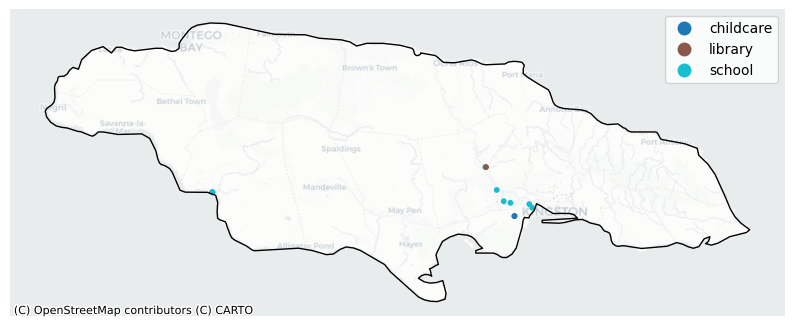

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

subset = damage_results.sort_values('damage',ascending=False).head(20)
subset.geometry = subset.centroid
subset.plot(ax=ax,column='object_type',markersize=10,legend=True)
features.plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()

And create a distribution of the damages.

<Axes: xlabel='damage', ylabel='Count'>

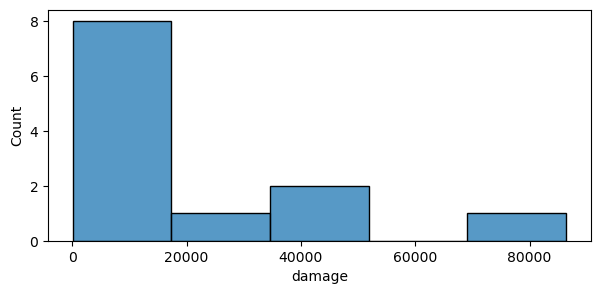

In [31]:
fig, ax = plt.subplots(1,1,figsize=(7, 3))

sns.histplot(data=damage_results,x='damage',ax=ax)

Plot all damages

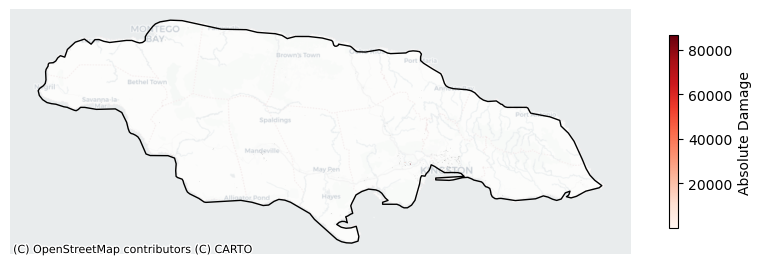

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

damage_results.plot(ax=ax,column='damage',cmap='Reds',legend=True,
                   legend_kwds={'shrink': 0.5,'label':'Absolute Damage'},zorder=5)
features.plot(ax=ax,facecolor="none",edgecolor='grey',alpha=0.5,zorder=2,lw=0.1)
world_plot.loc[world.SOV_A3 == country_iso3].plot(ax=ax,facecolor="none",edgecolor='black')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron,alpha=0.5)
ax.set_axis_off()